In [ ]:
import os
import numpy as np
import torch
import torchaudio
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Configuration
DATASET_PATH = "C:/Users/RIHAB-PC/OneDrive - Al Akhawayn University in Ifrane/Global_Music_Genre_Dataset1/Genres" 
SAMPLE_RATE = 22050
N_MFCC = 13

# MFCC extractor
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=N_MFCC,
    melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 40}
)

features= []
labels = []
skipped = 0

# Feature extraction loop
for genre in os.listdir(DATASET_PATH):
    genre_path = os.path.join(DATASET_PATH, genre)
    if not os.path.isdir(genre_path):
        continue
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)
            try:
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
                if len(y) == 0:
                    raise ValueError("Empty audio")

                waveform = torch.tensor(y).unsqueeze(0)
                mfcc = mfcc_transform(waveform)
                mfcc_mean = mfcc.mean(dim=2).squeeze().numpy()
                features.append(mfcc_mean)
                labels.append(genre)
            except Exception as e:
                skipped += 1
                print(f"[Skipped] {file_path}: {e}")

print(f"\n✅ Extracted {len(features)} samples, Skipped: {skipped} files")

# Prepare dataset
X = np.array(features)
le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

In [21]:
# 🎯 Predict and Evaluate
y_pred = clf.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


📊 Classification Report:

                   precision    recall  f1-score   support

          Ahidous       0.60      0.60      0.60        10
             Aita       0.69      0.90      0.78        10
           AuHaka       0.75      0.90      0.82        10
       AwKhaleeji       0.40      0.40      0.40        10
            AwPop       0.50      0.40      0.44        10
     ChPekinopera       0.54      0.70      0.61        10
          CuSalsa       0.50      0.20      0.29        10
        IrBandari       0.50      0.30      0.38        10
         MaChaabi       0.78      0.88      0.82         8
        MaChgouri       0.60      0.30      0.40        10
MaDakkamarrakchia       0.75      0.60      0.67        10
          MaGnawa       0.89      0.80      0.84        10
              RnB       0.29      0.40      0.33        10
        andalussi       0.83      1.00      0.91        10
            blues       0.64      0.70      0.67        10
         city pop       0.45

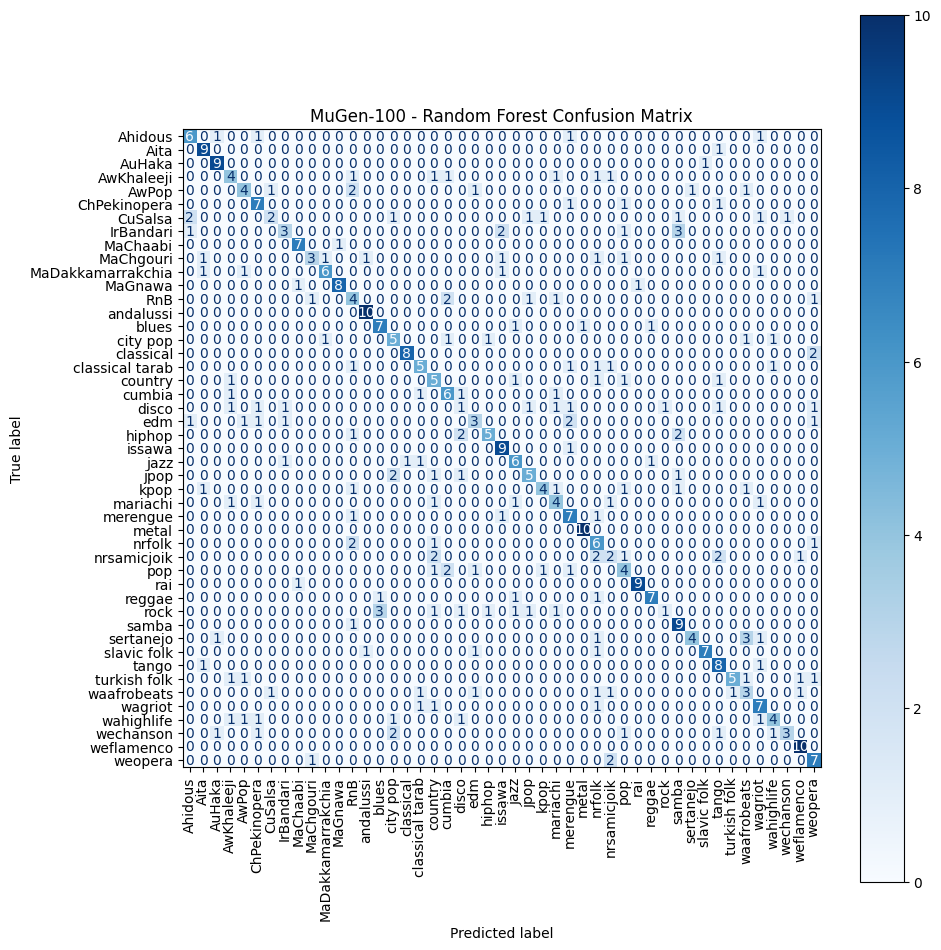

In [23]:
# 🔍 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90)
plt.title("MuGen-100 - Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()